<a href="https://colab.research.google.com/github/MerkulovDaniil/split-sgd/blob/master/Code/Continious_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General splitting and balancing

## Linear regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  3%|▎         | 3/100 [00:00<00:05, 18.22it/s]

QR finished
🤖 GF trajectory started
300
300
300
300


  5%|▌         | 5/100 [00:00<00:05, 16.34it/s]

300
300
300


  9%|▉         | 9/100 [00:00<00:06, 14.86it/s]

300
300
300


 11%|█         | 11/100 [00:00<00:06, 14.44it/s]

300
300
300


 15%|█▌        | 15/100 [00:01<00:06, 13.73it/s]

300
300
300


 17%|█▋        | 17/100 [00:01<00:06, 13.54it/s]

300
300
300


 21%|██        | 21/100 [00:01<00:06, 13.11it/s]

300
300
300


 23%|██▎       | 23/100 [00:01<00:05, 13.02it/s]

300
300
300


 27%|██▋       | 27/100 [00:01<00:05, 13.02it/s]

300
300
300


 29%|██▉       | 29/100 [00:02<00:05, 12.93it/s]

300
300
300


 33%|███▎      | 33/100 [00:02<00:05, 12.73it/s]

300
300
300


 35%|███▌      | 35/100 [00:02<00:05, 12.51it/s]

300
300
300


 39%|███▉      | 39/100 [00:02<00:04, 12.67it/s]

300
300
300


 41%|████      | 41/100 [00:03<00:04, 12.76it/s]

300
300
300


 45%|████▌     | 45/100 [00:03<00:04, 12.77it/s]

300
300
300


 47%|████▋     | 47/100 [00:03<00:04, 12.79it/s]

300
300
300


 51%|█████     | 51/100 [00:03<00:03, 12.81it/s]

300
300
300


 53%|█████▎    | 53/100 [00:04<00:03, 12.64it/s]

300
300
300


 57%|█████▋    | 57/100 [00:04<00:03, 12.40it/s]

300
300
300


 59%|█████▉    | 59/100 [00:04<00:03, 12.22it/s]

300
300
300


 63%|██████▎   | 63/100 [00:04<00:02, 12.38it/s]

300
300
300


 65%|██████▌   | 65/100 [00:05<00:02, 12.14it/s]

300
300
300


 69%|██████▉   | 69/100 [00:05<00:02, 12.27it/s]

300
300
300


 71%|███████   | 71/100 [00:05<00:02, 12.25it/s]

300
300
300


 75%|███████▌  | 75/100 [00:05<00:02, 12.22it/s]

300
300
300


 77%|███████▋  | 77/100 [00:06<00:01, 12.24it/s]

300
300
300


 81%|████████  | 81/100 [00:06<00:01, 12.19it/s]

300
300
300


 83%|████████▎ | 83/100 [00:06<00:01, 12.25it/s]

300
300
300


 87%|████████▋ | 87/100 [00:06<00:01, 12.33it/s]

300
300
300


 89%|████████▉ | 89/100 [00:06<00:00, 12.34it/s]

300
300
300


 93%|█████████▎| 93/100 [00:07<00:00, 11.99it/s]

300
300
300


 95%|█████████▌| 95/100 [00:07<00:00, 11.78it/s]

300
300
300


 97%|█████████▋| 97/100 [00:07<00:00, 11.81it/s]

300
300


100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


300
🤖 GF trajectory finished
🤖 SGD trajectory started
🤖 SGD trajectory finished
🤖 Splitting I trajectory started
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300

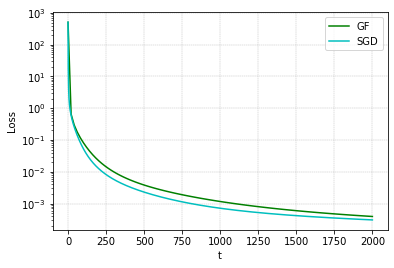

In [100]:
# ======= Libraries =======
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm, qr
import copy
from tqdm import tqdm

# ======= Function definitions =======

def generate_problem(p, n, lstsq=False, epsilon = 0):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + epsilon*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q, R, theta_0, y_batch, h, n):
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n*np.linalg.norm(X @ theta - y)**2
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s

        loss = 0
        for i_batch in range(s):
            loss += 1/n*np.linalg.norm(X[i_batch] @ theta - y[i_batch])**2
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')


def gradient(X, theta, y):
    n, p = X.shape
    return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, lr):
    theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
    return theta

def relative_error(theta, thetalstsq=0):
    p = len(theta)
    if np.linalg.norm(thetalstsq) != 0:
        return(np.linalg.norm(theta - thetalstsq)/np.linalg.norm(thetalstsq))
    else:
        return(np.linalg.norm(theta - np.ones(p))/np.linalg.norm(np.ones(p)))

def logarithmic_norm(A):
    w,v = np.linalg.eig((A + A.T)/2)
    return(max(w))

def gradient_flow_trajectory(Q, R, theta_0, y, ts):
    p, n = Q.shape
    print('🤖 GF trajectory started')
    thetas = []
    losses = []

    for t in tqdm(ts):
        theta_t = solve_local_problem(Q, R, theta_0, y, t, n)
        thetas.append(theta_t)
        loss_t = loss(R.T@Q.T, theta_t, y)
        losses.append(loss_t)
    
    print('🤖 GF trajectory finished')

    return thetas, losses

def sgd_trajectory(Xs, theta_0, ys, lr, N_epoch):
    print('🤖 SGD trajectory started')
    s, b, p = Xs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    for i_t in range(N_epoch):
        h = lr*n/b
        t+=h
        ts.append(t)
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)

        for i_batch in range(s):
            theta_t = make_SGD_step(Xs[i_batch], theta_t, ys[i_batch], lr)

    thetas.append(theta_t)
    loss_t = loss(Xs, theta_t, ys)
    losses.append(loss_t)  
    
    print('🤖 SGD trajectory finished')

    return thetas, losses, ts

def spl_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting I trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in range(len(ts)):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            # ts_new.append(ts[i_t] + i_batch*h/s)
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h, n)
       
    
    print('🤖 Splitting I trajectory finished')

    return thetas, losses

def spl2_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting II trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in range(len(ts)):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s-1):
            # ts_new.append(ts[i_t] + i_batch*h/(2*s))
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
        
        # ts_new.append(ts[i_t] + h/(*s))
        # thetas.append(theta_t)
        # loss_t = loss(Xs, theta_t, ys)
        # losses.append(loss_t)
        theta_t = solve_local_problem(Qs[s-1], Rs[s-1], theta_t, ys[s-1], h, n)

        for j_batch in range(s-1):
            i_batch = s - (j_batch + 2) 
            # ts_new.append(ts[i_t] + j_batch*h/(2*s))
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
    
    print('🤖 Splitting II trajectory finished')

    return thetas, losses

# ======= Problem generation =======

hs = np.logspace(-2, -1, 12)
p = 300
n = 300
s = 20
b = 15
n_max_iter = 2000
epsilon = 0
n_experiments = 30

X, theta_0, y, theta_lstsq = generate_problem(p,n, lstsq=True, epsilon=epsilon)

Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')

theta_0     = np.random.randn(p)
total_time  = 2000
learning_rate = 4e-2
N_epochs = int(total_time*b/(learning_rate*n))
h = learning_rate*s
ts_gf = np.linspace(0, total_time, 100)
ts_spl = np.linspace(0, total_time, 100)

# ======= Trajectory generation =======
thetas_gf, losses_gf    = gradient_flow_trajectory(Q, R, theta_0, y, ts_gf)
thetas_sgd, losses_sgd, ts_sgd  = sgd_trajectory(Xs, theta_0, ys, learning_rate, N_epochs)
thetas_spl, losses_spl = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
thetas_spl2, losses_spl2 = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)

plt.figure(figsize=(6.0, 4.0))
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'go', label = 'True')
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'g')
plt.semilogy(ts_gf, losses_gf, 'g', label = 'GF')
plt.semilogy(ts_sgd, losses_sgd, 'c', label = 'SGD')
# plt.semilogy(ts_spl, losses_spl, 'b', label = 'Splitting I')
# plt.semilogy(ts_spl, losses_spl2, 'r', label = 'Splitting II')
plt.grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
plt.xlabel('t')
plt.ylabel('Loss')
plt.legend()

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('convergence_lls.pdf')
plt.show()

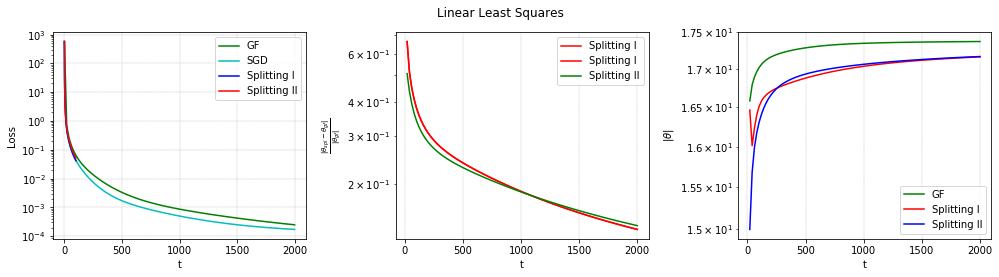

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Linear Least Squares')
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'go', label = 'True')
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'g')
axs[0].semilogy(ts_gf, losses_gf, 'g', label = 'GF')
axs[0].semilogy(ts_sgd, losses_sgd, 'c', label = 'SGD')
axs[0].semilogy(ts_spl/20, losses_spl, 'b', label = 'Splitting I')
axs[0].semilogy(ts_spl/20, losses_spl2, 'r', label = 'Splitting II')
axs[0].grid(True, linestyle='--', linewidth=0.4)
axs[0].set_xlabel('t')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].semilogy(ts_spl[1:], [np.linalg.norm(thetas_spl[i] - thetas_gf[i])/np.linalg.norm(thetas_gf[i]) for i in range(1, len(ts_spl))], 'r', label = 'Splitting I')
axs[1].semilogy(ts_spl[1:], [np.linalg.norm(thetas_spl[i] - thetas_gf[i])/np.linalg.norm(thetas_gf[i]) for i in range(1, len(ts_spl))], 'r', label = 'Splitting I')
axs[1].semilogy(ts_spl[1:], [np.linalg.norm(thetas_spl2[i] - thetas_gf[i])/np.linalg.norm(thetas_gf[i]) for i in range(1, len(ts_spl))], 'g', label = 'Splitting II')
axs[1].set_xlabel('t')
axs[1].set_ylabel(r'$\frac{\|\theta_{spl} - \theta_{gf}\|}{\|\theta_{gf}\|}$')
axs[1].grid(True, linestyle='--', linewidth=0.4)
axs[1].legend()

axs[2].semilogy(ts_spl[1:], [np.linalg.norm(thetas_gf[i]) for i in range(1, len(ts_spl))], 'g', label = 'GF')
axs[2].semilogy(ts_spl[1:], [np.linalg.norm(thetas_spl[i]) for i in range(1, len(ts_spl))], 'r', label = 'Splitting I')
axs[2].semilogy(ts_spl[1:], [np.linalg.norm(thetas_spl2[i]) for i in range(1, len(ts_spl))], 'b', label = 'Splitting II')
axs[2].set_xlabel('t')
axs[2].set_ylabel(r'$\|\theta\|$')
axs[2].grid(True, linestyle='--', linewidth=0.4)
axs[2].legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()